In [41]:
# install libraries
%pip install requests -q
%pip install scikit-learn -q
%pip install pandas -q
%pip install matplotlib -q
%pip install python-dotenv -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
# for api
import os
import requests
import json
from dotenv import load_dotenv

# for tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from collections import defaultdict

# for visualization
import matplotlib.pyplot as plt

In [43]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_endpoint = os.getenv('API_ENDPOINT')
user_id = os.getenv('USER_ID')

In [44]:
# get all my search queries
def get_queries(endpoint, user_id):
    # Construct the full URL
    url = f"{endpoint}/queries/{user_id}"
    # Send GET request to the API
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None  # Return None in case of an error

def clean_queries(data):
    return [{
        'content': item['content'].lower(),
        'score': item['score'],
        'timestamp': item['timestamp']
    } for item in data]

# create dictionary of tfidf scores for each word
def get_tfidf_scores(documents):
    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    idf = vectorizer.idf_
    return dict(zip(feature_names, idf))

# add tfidf scores to each document
def add_tfidf_scores(data, tfidf_scores):
    res = []
    for item in data:
        new_item = item.copy()  # Create a copy of the original item
        words = item['content'].split()
        sum_tfidf_score = sum(tfidf_scores.get(word, 0) for word in words)
        avg_tfidf_score = sum_tfidf_score / len(words)
        new_item['avg_tfidf_score'] = avg_tfidf_score  # Add the new key-value pair
        new_item['sum_tfidf_score'] = sum_tfidf_score
        res.append(new_item)
    return res

def create_data_frame(data):
    return pd.DataFrame({
        'query': [item['content'] for item in data],
        'avg_tfidf_score': [item['avg_tfidf_score'] for item in data],
        'sum_tfidf_score': [item['sum_tfidf_score'] for item in data],
        'user_score': [item['score'] for item in data]
    })

def draw_scatter_plot(data_frame, x_col, y_col):
    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(data_frame[x_col], data_frame[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs {y_col}')

    plt.legend()
    plt.show()

In [45]:
# fetch data and clean it
raw_data = get_queries(api_endpoint, user_id)
data = clean_queries(raw_data)


In [46]:
# Extract the 'content' field and 'score' from each document
documents = [item['content'] for item in data]
scores = [item['score'] for item in data]
        
tfidf_scores = get_tfidf_scores(documents)
data_with_tfidf = add_tfidf_scores(data, tfidf_scores)

result_df = create_data_frame(data_with_tfidf)

/var/folders/2r/pq8c0tps6xx_xx2cvwwjbsdc0000gn/T/ipykernel_63714/2114770334.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


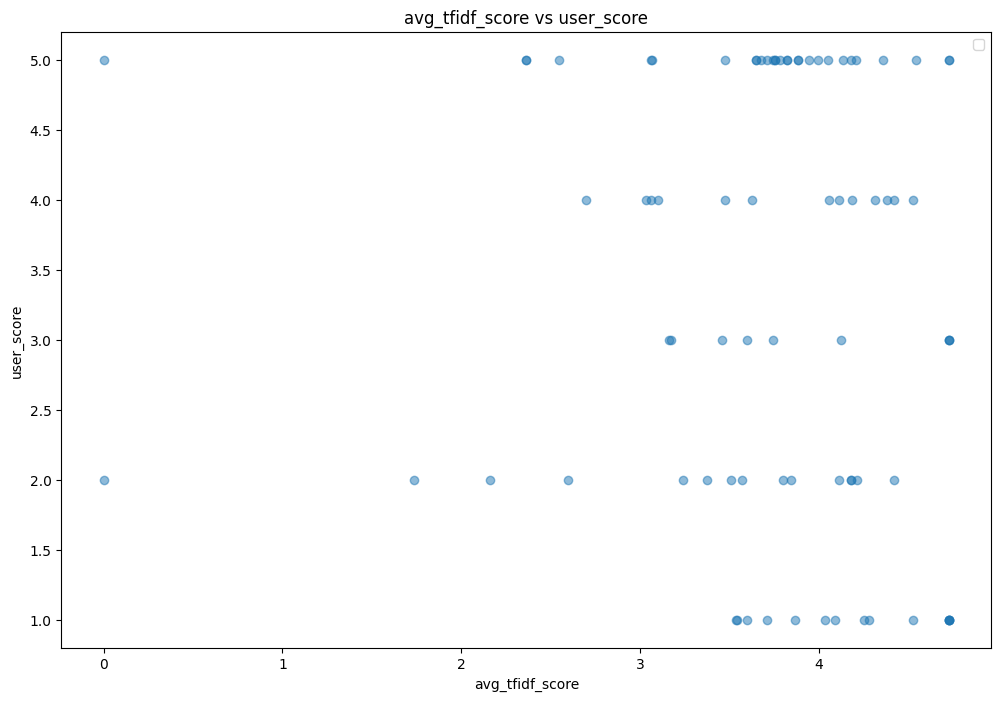

In [47]:
# draw average tfidf score vs user score
draw_scatter_plot(result_df, 'avg_tfidf_score', 'user_score')

/var/folders/2r/pq8c0tps6xx_xx2cvwwjbsdc0000gn/T/ipykernel_63714/2114770334.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


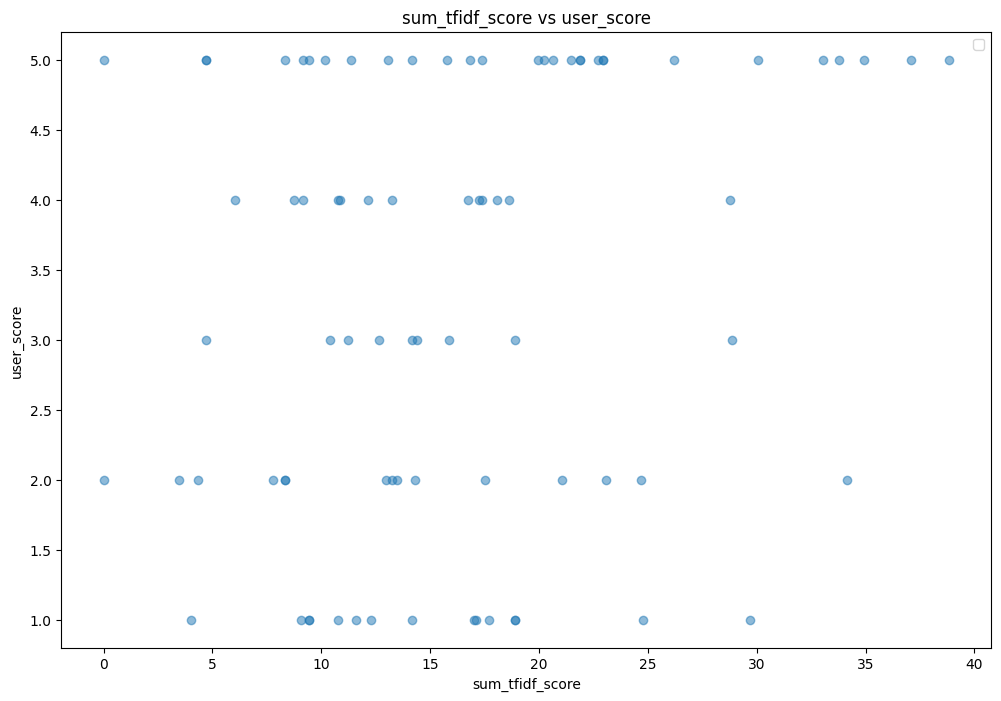

In [48]:
# draw sum tfidf score vs user score
draw_scatter_plot(result_df, 'sum_tfidf_score', 'user_score')